# 1. Data Obtaining
Data was found through web search and acquired at the repository of Dr. McAuley, Assistant Professor at UCSD (University of California San Diego) with his permission ([link](http://jmcauley.ucsd.edu/data/amazon/)). Review data is composed of 82 million review information from May 1996 and July 2014 and Metadata includes 9.4 million products' information. Both files were formatted in one-review-per-line loose JSON (list of JSONs). The reason it is loose JSON is unlike normal JSON files, we cannot load file conveniently and directly using json.load() from Python’s json library due to ‘\n’ (newline character) and double quote - single quote issues.
***
#### [review data example]
<pre>{ 
   "reviewerID": "A2SUAM1J3GNN3B", 
   "asin": "0000013714",
   "reviewerName": "J. McDonald",
   "helpful": [2, 3],
   "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  "overall": 5.0,
  "summary": "Heavenly Highway Hymns",
  "unixReviewTime": 1252800000,
  "reviewTime": "09 13, 2009"
} 
</pre>
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3 (2 people think this review is helpful out of 3 people who participated in voting helpfulness for the product)
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
***
#### [meta data example]
<pre>{
  "asin": "0000031852",
  "title": "Girls Ballet Tutu Zebra Hot Pink",
  "price": 3.17,
  "imUrl": "http://ecx.images-amazon.com/images/I/51fAmVkTbyL._SY300_.jpg",
  "related":
  {
    "also_bought": ["B00JHONN1S", "B002BZX8Z6", "B00D2K1M3O", "0000031909", "B00613WDTQ", "B00D0WDS9A", "B00D0GCI8S", "0000031895", "B003AVKOP2", "B003AVEU6G", "B003IEDM9Q", "B002R0FA24", "B00D23MC6W", "B00D2K0PA0", "B00538F5OK"],
    "also_viewed": ["B002BZX8Z6", "B00JHONN1S", "B008F0SU0Y", "B00D23MC6W", "B00AFDOPDA", "B00E1YRI4C", "B002GZGI4E", "B003AVKOP2", "B00D9C1WBM", "B00CEV8366", "B00CEUX0D8", "B0079ME3KU", "B00CEUWY8K", "B004FOEEHC", "0000031895", "B00BC4GY9Y", "B003XRKA7A", "B00K18LKX2", "B00EM7KAG6"],
    "bought_together": ["B002BZX8Z6"]
  },
  "salesRank": {"Toys & Games": 211836},
  "brand": "Coxlures",
  "categories": [["Sports & Outdoors", "Other Sports", "Dance"]]
}
</pre>
- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to
***

# 2. Data Importing

I referenced the author's guildline for importing loose JSON data into data frame. However, due to the fact that the data itself is too large to import all at once. I "chunk-ifyied" data into set of data (splitted into 10 review sub-data frames). 

<div class="alert alert-block alert-danger">
<b>Warning:</b> following this procedure may take quite a long time.
</div>

### Helper functions

In [1]:
# %load wrangling.py
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import gzip

def parse(path):
    """
    Helper function to parse the data compressed in .gz format line by line
    
    Input: path of original file
    Output: generator of parsed data. This is used in getMeta(), getDF() functions
    """
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getMeta(path):
    """
    Helper function to read the meta data in loose JSON form into pandas DataFrame
    
    Input: path of the file
    Output: DataFrame of meta data
    """
    i = 0
    meta = {}
    for d in parse(path):
        meta[i] = d
        i += 1
    return pd.DataFrame.from_dict(meta, orient='index')

def getDF(path, ind=0):
    """
    Helper function to read the review data in loose JSON form into pandas DataFrame
    
    Input: path of the file
    Output: DataFrame of review data
    """
    # each time get 1/10 of DF
    chunksize = ((82456877 // 100)*10)+10 # 8245690 
    i = 0
    df = {}
    for d in parse(path):
        if (i >= ind*chunksize) and (i < (ind+1)*chunksize):
            df[i] = d
        i += 1
        if i == (ind+1)*chunksize:
            break
    return pd.DataFrame.from_dict(df, orient='index')

### 2.a. Spliting original data into 10 review data frames

In [2]:
## Reading original data
meta_df = getMeta('metadata.json.gz')
df_0 = getDF('aggressive_dedup.json.gz', ind=0) 
df_1 = getDF('aggressive_dedup.json.gz', ind=1) 
df_2 = getDF('aggressive_dedup.json.gz', ind=2) 
df_3 = getDF('aggressive_dedup.json.gz', ind=3) 
df_4 = getDF('aggressive_dedup.json.gz', ind=4)
df_5 = getDF('aggressive_dedup.json.gz', ind=5)
df_6 = getDF('aggressive_dedup.json.gz', ind=6) 
df_7 = getDF('aggressive_dedup.json.gz', ind=7)
df_8 = getDF('aggressive_dedup.json.gz', ind=8) 
df_9 = getDF('aggressive_dedup.json.gz', ind=9)

# 3. Manipulating/Filtering Data

We focus on reviews with more than 9 of helpful denominator and less than 10,000 of helpful denominator, for small number of participants is hard to believe the model prediction is well generalized and more than 10,000 helpful denominator is rare so I regarded those entries as outlier. You can think of helpful denominator as voter population and helpful numerator as number of people who voted for a particular review. 

<div class="alert alert-block alert-warning">
<b>Recall:</b> 'helpful' feature is in such a format as [2, 3] which is equivalent to 2/3 and interpreted as 2 people think this review is helpful out of entire 3 people who participated in voting helpfulness for the product. By construction, I will call 2 <b>"helpful numerator"</b> and 3 <b>"helpful denominator"</b>. Therefore, helpful [2, 3] is read as 'helpful numerator 2 and helpful denominator 3'. </div>

In [4]:
def df_filter(df):
    """
    Filter data so that it can have entries with more than helpful denominator 9 and less than 10,000; 
    and parse date
    
    Input: data frame
    Output: data frame
    """
    # filter out for data with helpful score (9 ,  10000]
    df = df[(df.helpful.map(lambda x: x[1]) > 9) & (df.helpful.map(lambda x: x[1]) < 10000)]
    # convert reviewTime from str to datetime
    df = df[df.reviewTime.map(lambda x: x[:2]).isin(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])]
    df['reviewTime'] = pd.to_datetime(df['reviewTime'])

    return df

### 3.a. Filtering data frames

In [5]:
## drop columns unnecessary
meta_df = meta_df.drop(['related', 'imUrl'], axis=1) 
## filter review data frames ith df_filter()
df_0 = df_filter(df_0) 
df_1 = df_filter(df_1)
df_2 = df_filter(df_2) 
df_3 = df_filter(df_3) 
df_4 = df_filter(df_4) 
df_5 = df_filter(df_5) 
df_6 = df_filter(df_6) 
df_7 = df_filter(df_7) 
df_8 = df_filter(df_8) 
df_9 = df_filter(df_9) 

### 3.b. Merging review data and meta data

In [6]:
## concatenate review sub data frames
df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9], axis=0)

In [7]:
meta_df.info(), df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9430088 entries, 0 to 9430087
Data columns (total 7 columns):
asin           object
salesRank      object
categories     object
title          object
description    object
price          float64
brand          object
dtypes: float64(1), object(6)
memory usage: 575.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4944438 entries, 86 to 82456875
Data columns (total 9 columns):
reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall           float64
summary           object
unixReviewTime    float64
reviewTime        datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 377.2+ MB


We can confirm that df and meta_df can be merged on 'asin'

In [10]:
# Check each item has unique asin
df.asin.value_counts().head()

0425269205    3973
1892112000    3498
031604461X    3320
B000FI73MA    3099
B00178630A    2968
Name: asin, dtype: int64

In [11]:
meta_df.asin.value_counts().head()

B004FAIOVI    1
B0057B52E6    1
B00DJBP570    1
B00GMQI9D6    1
B000EX337A    1
Name: asin, dtype: int64

As seen above, product ID (asin) is unique in meta_df unlike that of df's. Therefore, when merging, we should set 'validate' as 'many_to_one' or 'm:1'

In [12]:
# merging
df = pd.merge(df, meta_df, how='inner', on='asin', validate='many_to_one')

In [13]:
df.shape

(4753979, 15)

In [14]:
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,salesRank,categories,title,description,price,brand
0,A0001528BGUBOEVR6T5U,B008O5BIWW,igozingo,"[4, 14]",The Foscam FI8919W is a great camera. I am a d...,5.0,Foscam FI8919W,1.360714e+09,2013-02-13,{},"[[Electronics, Camera & Photo, Video Surveilla...",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...,189.73,Foscam
1,A1S44FJFOKDV4Q,B008O5BIWW,David,"[10, 13]",Purchased this camera direct from Foscam. The...,1.0,Nothing but problems,1.380758e+09,2013-10-03,{},"[[Electronics, Camera & Photo, Video Surveilla...",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...,189.73,Foscam
2,A20WKTYKTJPRDW,B008O5BIWW,"Chris ""CS""","[10, 13]",This was my 8th or 9th Foscam and my first exp...,1.0,Good technology horrible support camera cannot...,1.373933e+09,2013-07-16,{},"[[Electronics, Camera & Photo, Video Surveilla...",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...,189.73,Foscam


It seems all columns are joined well. Also, we notice herein that there is some loss of data after merging

# 4. Cleaning Data
In this section, I will deal with missing values and simplify categories.
### 4.a. Removing duplicated features

In [15]:
## We do not need entries without reviewText
df = df[~df.reviewText.isnull()]

In [17]:
## Investigate missing value percentage
df.isnull().sum() / df.shape[0] * 100

reviewerID         0.000000
asin               0.000000
reviewerName       0.319143
helpful            0.000000
reviewText         0.000000
overall            0.000000
summary            0.000000
unixReviewTime     0.000000
reviewTime         0.000000
salesRank         15.842014
categories         0.576170
title             14.582458
description       15.586838
price             12.043028
brand             75.951619
dtype: float64

There are 5 features which have 12+% missings, and 2 features with 0.6-% missings. Especially brand has around 76% missing proportion. We can assume that brand is not meaningful feature and thus drop the column. Also, both unixReviewTime and reviewTime mean the same and the only difference is format. Hence, we drop unixReviewTime column. Finally, we do not need both reviewerName and reviewerId since we can identify a reviewer with his/her ID.

In [18]:
df = df.drop(columns=['brand', 'unixReviewTime', 'reviewerName'])

### 4.b. Handling 'title', 'description' and 'price' columns
These 3 columns have rather big proportion of missing vlaues. Let us see if we can filling the missing spots.

In [20]:
no_title_asin = df[df['title'].isnull()]['asin'].unique()
no_description_asin = df[df['description'].isnull()]['asin'].unique()
no_price_asin = df[df['price'].isnull()]['asin'].unique()

In [21]:
## hoping that some rows have title of the same product ID (asin)
print(df[df['asin'].isin(no_title_asin)]['title'].isnull().sum()/df[df['asin'].isin(no_title_asin)]['title'].shape[0])

## Ditto; description
print(df[df['asin'].isin(no_description_asin)]['description'].isnull().sum()/df[df['asin'].isin(no_description_asin)]['description'].shape[0])

## Ditto; price
print(df[df['asin'].isin(no_price_asin)]['price'].isnull().sum()/df[df['asin'].isin(no_price_asin)]['price'].shape[0])

1.0
1.0
1.0


It seems that there are no items of same asin (product ID) that preserve 'title', 'description' or 'price'

In [22]:
df[['asin', 'helpful', 'title', 'description']].head(10)

,asin,helpful,title,description
0,B008O5BIWW,"[4, 14]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
1,B008O5BIWW,"[10, 13]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
2,B008O5BIWW,"[10, 13]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
3,B008O5BIWW,"[19, 20]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
4,B008O5BIWW,"[14, 16]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
5,B008O5BIWW,"[13, 17]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
6,B008O5BIWW,"[92, 102]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
7,B008O5BIWW,"[5, 14]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
8,B008O5BIWW,"[14, 15]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...
9,B008O5BIWW,"[9, 12]",Foscam FI8919W Outdoor Pan and Tilt Wireless I...,Foscam Fi8919W Outdoor Pan and Tilt Wireless I...


All rows of same product id share title and description, which means it does not have any difference among these rows and it is no use for analysis. Therefore, we drop title and description columns. However, I believe price can have impact on helpfulness score in that if a product is very expensive, more people would like to find helpful reviews and evaluate them. For this reason, I instead dropped rows without price.


In [23]:
## drop 'description' & 'title' columns
df = df.drop(columns=['description', 'title'])

## drop rows wihtout price
idx = df[df['price'].isnull()].index
df = df.drop(idx)

In [25]:
df.isnull().sum() 

reviewerID         0
asin               0
helpful            0
reviewText         0
overall            0
summary            0
reviewTime         0
salesRank     502905
categories     20398
price              0
dtype: int64

We can confirm those 3 columns are dealt with properly

### 4.c. Simplifying Categories
At first glance, salesRank and categories column includes similar information. Therefore, it is natural to attmept filling missing values in categories column with the help of salesRank. However, after a study, I came to conclusion that salesRank does not help with filling the missing spot in categories column. Furthermore, since categories column's missing rate is very small (~0.6%) and that of salesRank is over 15%. I drop salesRank column and remove rows without categories value.

In [26]:
df[['salesRank', 'categories']].tail()

,salesRank,categories
4753974,NaN,"[[Electronics, Camera & Photo, Accessories, Ba..."
4753975,{'Music': 123986},"[[CDs & Vinyl, Alternative Rock, Goth & Indust..."
4753976,{'Health & Personal Care': 6766},"[[Health & Personal Care, Vitamins & Dietary S..."
4753977,{'Books': 2583280},[[Books]]
4753978,{'Clothing': 5386},"[[Clothing, Shoes & Jewelry, Men, Accessories,..."


In [27]:
# drop salesRank column
df = df.drop(['salesRank'], axis=1)

# fill missing values with column's default missing value
df['categories'] = df['categories'].fillna("[['']]")

One might noticed that categories column has too many items in one cell, and if you see the list closely, more general categories come before less general ones. For this reason, I extract the first category in the list

In [43]:
## extract first category in categories column and update the column with the value
df['categories'] = df['categories'].map(lambda x: x[0][0])

In [48]:
df['categories'].unique(), len(df['categories'].unique())

(array(['Electronics', 'Tools & Home Improvement', 'Movies & TV', 'Books',
        'Video Games', 'Automotive', 'Pet Supplies',
        'Health & Personal Care', 'Home & Kitchen', 'Toys & Games',
        'Arts, Crafts & Sewing', 'CDs & Vinyl', 'Baby',
        'Sports & Outdoors', 'Gift Cards', 'Office Products',
        'Cell Phones & Accessories', 'Beauty', 'Clothing, Shoes & Jewelry',
        'Software', 'Industrial & Scientific', '', 'Patio, Lawn & Garden',
        'Grocery & Gourmet Food', 'Musical Instruments', 'Amazon Fashion',
        'Appliances', 'MP3 Players & Accessories', 'All Electronics',
        'Kindle Store', 'Digital Music', 'Apps for Android', '[',
        'Buy a Kindle', 'Amazon Instant Video', 'Magazine Subscriptions',
        'All Beauty', 'Baby Products', 'Purchase Circles', 'Classical',
        'Computers', 'Luxury Beauty', 'Rap & Hip-Hop', 'Rock',
        'Kitchen & Dining', 'Celebrate your Birthday with Nickelodeon',
        'Classic Rock', 'Home Improvement',

Missing values are respresented as ''. I will delete weird names ('\[', '#508510') and change 'Furniture & D# 233;cor' to 'Furniture' 

In [52]:
## drop missing value and weird name rows
dropnames = ['', '[', '#508510']
df = df[~df['categories'].isin(dropnames)]

In [59]:
## replace name to Furniture
df['categories'] = df['categories'].replace({'Furniture & D&#233;cor': 'Furniture'})

In [61]:
df.isnull().sum()

reviewerID    0
asin          0
helpful       0
reviewText    0
overall       0
summary       0
reviewTime    0
categories    0
price         0
dtype: int64

Now data frame is free from missing values

# 5. Converting Certain Columns

As you know overall rating is on a scale of 0 to 5 and helpfulness is in such a format as \[4, 14]. This is difficult to utilize to our end and therefore, I converted this metric to 0-5 rating metric same as overall rating. After this procedure, I will combine summary and reviewText together.

### 5.a. Transforming and scaling halpfulness
Let's convert helpfulness score to 0-5 scale rating as is overall rating <br><br>
$$ helpful\_num : helpful\_den = rating : 5 $$ <br>
$$ \therefore rating = 5 \times \frac{helpful\_num}{helpful\_den} $$

In [67]:
df['helpful'].head()

0     [4, 14]
1    [10, 13]
2    [10, 13]
3    [19, 20]
4    [14, 16]
Name: helpful, dtype: object

In [70]:
## Extract 'helpful numerator' out of 'helpful' column
df['helpful_num'] = df['helpful'].map(lambda x: x[0])

## Extract 'helpful denominator' out of 'helpful' column
df['helpful_den'] = df['helpful'].map(lambda x: x[1])

## drop 'helpful' column
df = df.drop(columns=['helpful'])

In [73]:
## make helpfulness rating of 0-5 scale
df['helpfulness'] = df[['helpful_num', 'helpful_den']].apply(lambda x: 5*x['helpful_num']/x['helpful_den'], axis=1)

In [74]:
## show value counts of 'overall' (rating)
df['overall'].value_counts()

5.0    1860595
1.0     943340
4.0     559808
3.0     403734
2.0     385529
Name: overall, dtype: int64

As seen above, overall rating is descrete numbers from 0 to 5. Let's take a further step to transform helpfulness rating by rounding.

In [75]:
df['helpfulness'] = df['helpfulness'].map(np.round)
## show value counts
df['helpfulness'].value_counts()

5.0    1547985
4.0    1211216
3.0     461126
2.0     408169
1.0     318604
0.0     205906
Name: helpfulness, dtype: int64

### 5.b. Combining summary and reviewText
As I checked at Amazon website, and from this data, summary and reviewText are written up in seperate boxes. Therefore, I regarded summary as part of review and combined them together in the fashion that summary is the first sentence(s) and I created new column “review” and dropped the two columns.

In [76]:
## example
print(df['summary'].iloc[50000])
print(df['reviewText'].iloc[50000])

special offers???
i have not purchased this yet.... i know i will be, however, the special offers. Can they be turned off? i cannot belive to purchaase the kindle touch without "special offers" is $40 more!?!?!? Does anyone know if they can be turned off?


In [81]:
## combining 'summary' and 'reviewText' 
df['review'] = df[['summary', 'reviewText']].apply(lambda x: '. '.join(x), axis=1)

# ## drop 'summary' and 'reviewText' columns
# df = df.drop(columns=['summary', 'reviewText'])

In [83]:
## drop 'summary' and 'reviewText' columns
df = df.drop(columns=['summary', 'reviewText'])

In [84]:
## Show current looking of data
print(df.shape)
df.head(3)

(4152941, 10)


,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,helpful_den,helpfulness,review
0,A0001528BGUBOEVR6T5U,B008O5BIWW,5.0,2013-02-13,Electronics,189.73,4,14,1.0,Foscam FI8919W. The Foscam FI8919W is a great ...
1,A1S44FJFOKDV4Q,B008O5BIWW,1.0,2013-10-03,Electronics,189.73,10,13,4.0,Nothing but problems. Purchased this camera di...
2,A20WKTYKTJPRDW,B008O5BIWW,1.0,2013-07-16,Electronics,189.73,10,13,4.0,Good technology horrible support camera cannot...


# 6. Appeasing Data Skewness
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized.

### 6.a. Appeasing skewness in Helpfulness
Helpfulness is our target column and therefore we should check its distribution first.

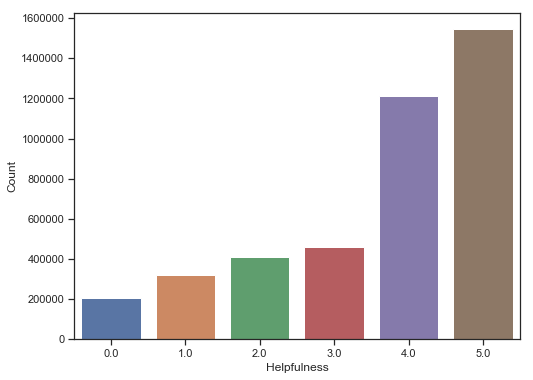

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

## Visualize helpfulnee distribution
hp = df['helpfulness'].value_counts().reset_index()
hp = hp.rename(columns={'index': 'Helpfulness', 'helpfulness': 'Count'})
plt.figure(figsize=(8,6))
sns.barplot(x='Helpfulness', y='Count', data=hp);

We can tell helpfulness is left-skewed. Still, 0 count and 5 count ratio is not very severe to intimidate the quality of model. However, for operation, I will reduce size to 0.3.

In [86]:
## value counts of helpfulness ratings
hp

,Helpfulness,Count
0,5.0,1547970
1,4.0,1211207
2,3.0,461121
3,2.0,408161
4,1.0,318596
5,0.0,205886


In [87]:
## in each helpfulness class, randomly sample 206000 rows
hp0 = df[df['helpfulness']==0].sample(frac=0.3, random_state=614)
hp1 = df[df['helpfulness']==1].sample(frac=0.3, random_state=614)
hp2 = df[df['helpfulness']==2].sample(frac=0.3, random_state=614)
hp3 = df[df['helpfulness']==3].sample(frac=0.3, random_state=614)
hp4 = df[df['helpfulness']==4].sample(frac=0.3, random_state=614)
hp5 = df[df['helpfulness']==5].sample(frac=0.3, random_state=614)

In [90]:
## concatenate dataframes
df = pd.concat([hp0, hp1, hp2, hp3, hp4, hp5], axis=0)

## sort data frame by product id (asin)
df = df.sort_values(by='asin')

## reset index
df = df.reset_index(drop=True)

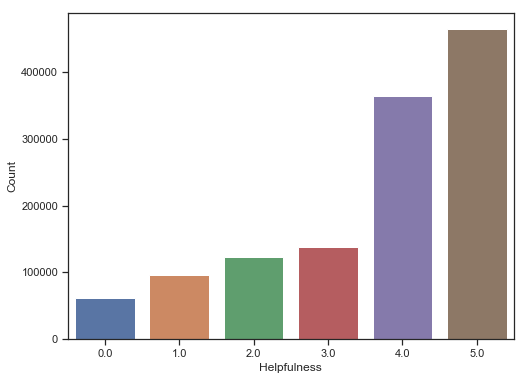

In [91]:
## Visualize distribution of helpfulness ratings after random stratified sampling
hp = df['helpfulness'].value_counts().reset_index()
hp = hp.rename(columns={'index': 'Helpfulness', 'helpfulness': 'Count'})
plt.figure(figsize=(8,6))
sns.barplot(x='Helpfulness', y='Count', data=hp);

Now, data is distributed in the same manner but our data size is reduced from 4.15M rows to about 1.24M rows

### 6.b. Appeasing skewness in Helpfulness
We may as well check price distribution because price can vary a lot. 

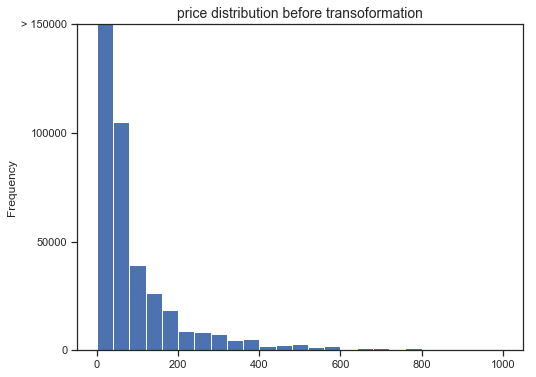

In [92]:
ax = df.price.plot(kind='hist', bins=25, figsize=(8, 6))
ax.set_title("price distribution before transoformation", fontsize=14)
ax.set_ylim((0, 150000))
ax.set_yticks([0, 50000, 100000, 150000])
ax.set_yticklabels([0, 50000, 100000, "> 150000"]);

We can tell price is highly right skewed. According to [wikipedia][1], when there is evidence of substantial skew in the data, it is common to transform the data to a symmetric distribution. Using logarithmic transformations will help the data spread more evenly and the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so I translate the values by a small amount above 0 to apply the the logarithm successfully. 

[1]: https://en.wikipedia.org/wiki/Data_transformation_(statistics)

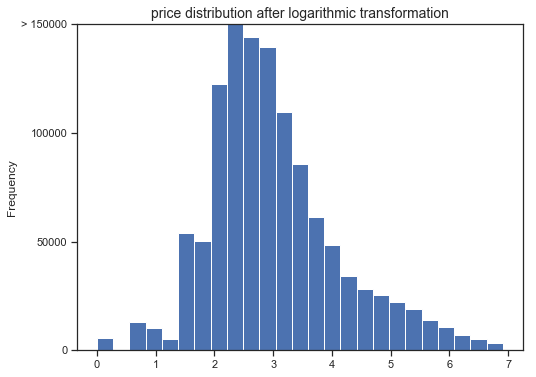

In [93]:
## to prevent log0 case, let us add 1
df['price'] = df['price'].apply(lambda x: np.log(x + 1))

## Visualize distribution after loogarithmic transformation
ax = df['price'].plot(kind='hist', bins=25, figsize=(8, 6))
ax.set_title("price distribution after logarithmic transformation", fontsize=14)
ax.set_ylim((0, 150000))
ax.set_yticks([0, 50000, 100000, 150000])
ax.set_yticklabels([0, 50000, 100000, "> 150000"]);

Price is now distributed more symmetrically.

In [94]:
## Show current looking of data
print(df.shape)
df.head(3)

(1245882, 10)


,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,helpful_den,helpfulness,review
0,A1TADCM7YWPQ8M,0000000868,4.0,2002-09-11,Books,3.128951,10,10,5.0,Not a Bad Translation. I'll be honest. I work ...
1,A3H1W0DWLW5DLH,0000031887,5.0,2010-10-10,"Clothing, Shoes & Jewelry",2.052841,26,28,5.0,Very happy customer. I bought this as part of ...
2,A2MPIVS0KSY8O0,0000032034,5.0,2013-09-10,Sports & Outdoors,2.182675,11,12,5.0,Tutus. Purchased and wore these tutus for the ...


### 7. Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution. However, normalization ensures that each feature is treated equally when applying supervised learners. For these reasons, I normalized price.  Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning.

In [95]:
from sklearn.preprocessing import MinMaxScaler

ser = df[['price']].copy()

# scale to [0, 1] using sklearn MinMaxScaler() function
scaler = MinMaxScaler()
ser = scaler.fit_transform(ser)

df['price'] = ser

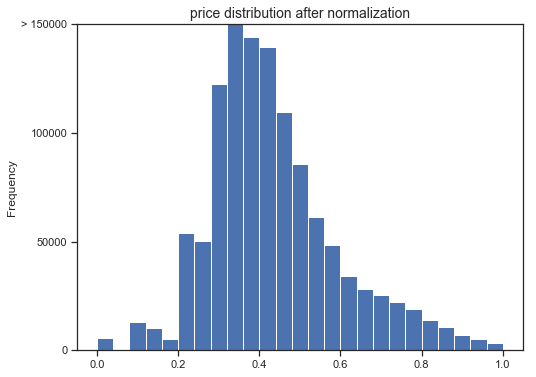

In [96]:
## Visualization 
ax = df['price'].plot(kind='hist', bins=25, figsize=(8, 6))
ax.set_title("price distribution after normalization", fontsize=14)
ax.set_ylim((0, 150000))
ax.set_yticks([0, 50000, 100000, 150000])
ax.set_yticklabels([0, 50000, 100000, "> 150000"]);

# 8. Finalizing Data
In this section, we discuss whether we should keep help_num and helpful_den columns and category distribution

### 8.a. Checking correlation among 'helpful_num', 'helpful_den', and 'helpfulness'

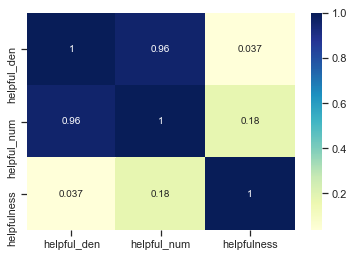

In [97]:
sns.heatmap(df[['helpful_den', 'helpful_num', 'helpfulness']].corr(), annot=True, cmap='YlGnBu');

Heatmap shows that helpful_num has 0.18 correlation to helpfulness and on the other hand, helpful_den has rather low correlation which is 0.037. This seems natural outcome because no matter how many people voted, it does not change the groundtruth - to get higher helpfulness rating, more people need to vote for the review. So we keep helpful_num and drop helpful_den.

In [98]:
## drop 'helpful_num' column
df = df.drop(columns=['helpful_den'])

### 8.b. Finalizing category
From earlier steps, we learned that there are 72 categories. If there are many categories, it gets cumbersome when we later process and we do not want to learn our model on small size categories. Like how we did at Step 3. Filtering Data. I will cut categories off at 400 because some categories only have 1, 3, or small number of products.

In [99]:
df['categories'].unique().shape

(71,)

In [100]:
## See head and tail of counts of categories 
cat_ser = df.categories.value_counts()

## show top, bottom 10
print(cat_ser.head(10)) 
print(cat_ser.tail(10))

Books                       558400
Movies & TV                 125968
CDs & Vinyl                 111716
Electronics                 102527
Home & Kitchen               50224
Health & Personal Care       40612
Video Games                  34267
Sports & Outdoors            27100
Tools & Home Improvement     23793
Toys & Games                 20951
Name: categories, dtype: int64
Country                 9
New Age                 8
R&B                     7
Folk                    7
Blues                   5
Wine                    5
Amazon Coins            3
Broadway & Vocalists    3
Rap & Hip-Hop           2
Children's Music        1
Name: categories, dtype: int64


In [101]:
print(cat_ser[cat_ser > 400].shape[0])
cat_ser[cat_ser > 400]

30


Books                        558400
Movies & TV                  125968
CDs & Vinyl                  111716
Electronics                  102527
Home & Kitchen                50224
Health & Personal Care        40612
Video Games                   34267
Sports & Outdoors             27100
Tools & Home Improvement      23793
Toys & Games                  20951
Beauty                        18817
Cell Phones & Accessories     16996
Office Products               16338
Patio, Lawn & Garden          13033
Clothing, Shoes & Jewelry     12806
Grocery & Gourmet Food        10446
Software                      10049
Pet Supplies                   9729
Baby                           9124
Automotive                     7291
Musical Instruments            5673
Arts, Crafts & Sewing          5118
Buy a Kindle                   3016
Industrial & Scientific        2777
Appliances                     1286
Magazine Subscriptions         1148
Baby Products                   999
Digital Music               

Cutting off at 400, we ended up with 31 categories

In [102]:
## to check how much data we lost
before = df.shape[0]

## filter out
df = df[df['categories'].isin(cat_ser[cat_ser > 400].index)]

## loss proportion
after = df.shape[0]
print((before - after) / before * 100)

0.26776211551334717


In [108]:
## Show shape and head of data
print(df.shape)
df.head(10)

(1242546, 9)


,reviewerID,asin,overall,reviewTime,categories,price,helpful_num,helpfulness,review
0,A1TADCM7YWPQ8M,0000000868,4.0,2002-09-11,Books,0.452897,10,5.0,Not a Bad Translation. I'll be honest. I work ...
1,A3H1W0DWLW5DLH,0000031887,5.0,2010-10-10,"Clothing, Shoes & Jewelry",0.297137,26,5.0,Very happy customer. I bought this as part of ...
2,A2MPIVS0KSY8O0,0000032034,5.0,2013-09-10,Sports & Outdoors,0.315929,11,5.0,Tutus. Purchased and wore these tutus for the ...
3,A30WLYNJA3B17H,0000589012,5.0,2008-10-23,Movies & TV,0.409665,8,4.0,Human Connection and Compassion. There is a tu...
4,A3LDEBLV6MVUBE,0000589012,5.0,2008-04-24,Movies & TV,0.409665,10,5.0,Why don't They Just Quit. The best book ever t...
5,A2SLVVXPRB60JC,0000913154,5.0,2000-11-19,Books,0.461564,12,5.0,A classic book on technology. One of a kind bo...
6,A2052JNVUPRTMT,000100039X,5.0,2000-11-10,Books,0.232667,97,5.0,Pure Wisdom. Gibran gets right down to the bed...
7,AJG3H9IGTOALP,000100039X,5.0,2002-02-13,Books,0.232667,11,4.0,One Of The Deepest Human Thoughts Ever Written...
8,AHD101501WCN1,000100039X,4.0,2006-04-26,Books,0.232667,9,3.0,Mixed feelings Inspiring poetry or vague senti...
9,A2ZB1G1KUE6OS6,000100039X,2.0,2009-05-03,Books,0.232667,0,0.0,Unexpected purchase. I evidently misread the w...


we only lost 0.27%

In [109]:
df.to_csv('./h5_filtered/df_clean_final.csv.gz', encoding='utf-8', index=False, compression='gzip')